In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils import data
from eegnet_repl.dataset import build_dataset_from_preprocessed

# Load processed data

In [46]:
dataset = build_dataset_from_preprocessed(src='kaggle', subject=4)

2026-01-14 13:26:20,196 - dataset.py - build_dataset_from_preprocessed - INFO - Building dataset from preprocessed data in D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed
2026-01-14 13:26:20,198 - dataset.py - build_dataset_from_preprocessed - INFO - Found 1 preprocessed files for subject 4


Opening raw data file D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed\A04T-preprocessed.fif...
    Range : 0 ... 307667 =      0.000 ...  2403.648 secs
Ready.
Reading 0 ... 307667  =      0.000 ...  2403.648 secs...
Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
Not setting metadata
144 matching events found
No baseline correction applied


D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\src\eegnet_repl\dataset.py:163: RuntimeWarning: This filename (D:\!Studying\NeuroData\DS_n_advanced_python\HW\Final_project_DS\code\EEGNetReplication\data\processed\A04T-preprocessed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  pp = mne.io.read_raw_fif(file, preload=True)


0 projection items activated
Using data from preloaded Raw for 144 events and 257 original time points ...
0 bad epochs dropped


In [47]:
dataset.X.shape

(144, 22, 257)

In [48]:
train_data, val_data = data.random_split(dataset=dataset,lengths=[0.8,0.2])

In [49]:
# 2.1. create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)

# 2.2. create data loader for the valset (batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_data, batch_size=32, shuffle=False)

In [50]:
dataiter = iter(train_loader)
batch_eeg, batch_labels = next(dataiter)

In [51]:
batch_eeg.shape

torch.Size([32, 22, 257])

In [52]:
batch_labels

tensor([8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7, 7, 8, 8, 7, 7, 8, 7, 7,
        8, 8, 8, 7, 7, 7, 8, 8])

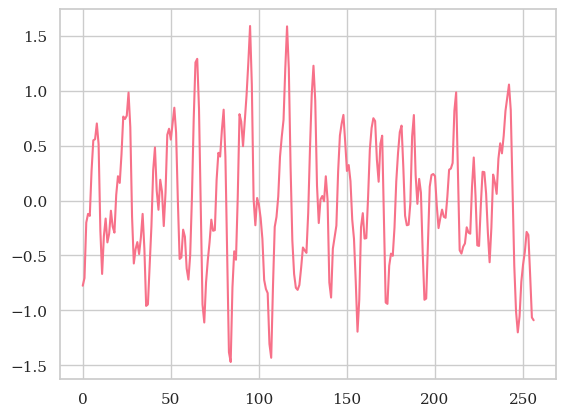

In [53]:
plt.plot(batch_eeg[0,0,:])

In [54]:
df = pd.DataFrame(batch_eeg[0].T)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       257 non-null    float64
 1   1       257 non-null    float64
 2   2       257 non-null    float64
 3   3       257 non-null    float64
 4   4       257 non-null    float64
 5   5       257 non-null    float64
 6   6       257 non-null    float64
 7   7       257 non-null    float64
 8   8       257 non-null    float64
 9   9       257 non-null    float64
 10  10      257 non-null    float64
 11  11      257 non-null    float64
 12  12      257 non-null    float64
 13  13      257 non-null    float64
 14  14      257 non-null    float64
 15  15      257 non-null    float64
 16  16      257 non-null    float64
 17  17      257 non-null    float64
 18  18      257 non-null    float64
 19  19      257 non-null    float64
 20  20      257 non-null    float64
 21  21      257 non-null    float64
dtypes:

2026-01-14 13:26:20,840 - category.py - update - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-14 13:26:20,849 - category.py - update - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


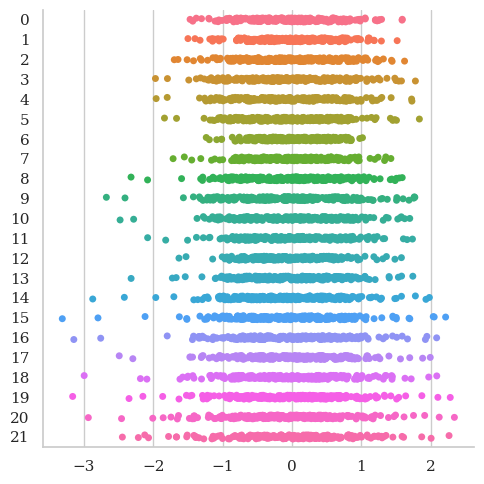

In [55]:
sns.catplot(data=df,kind='strip', orient='y')

# Architecture

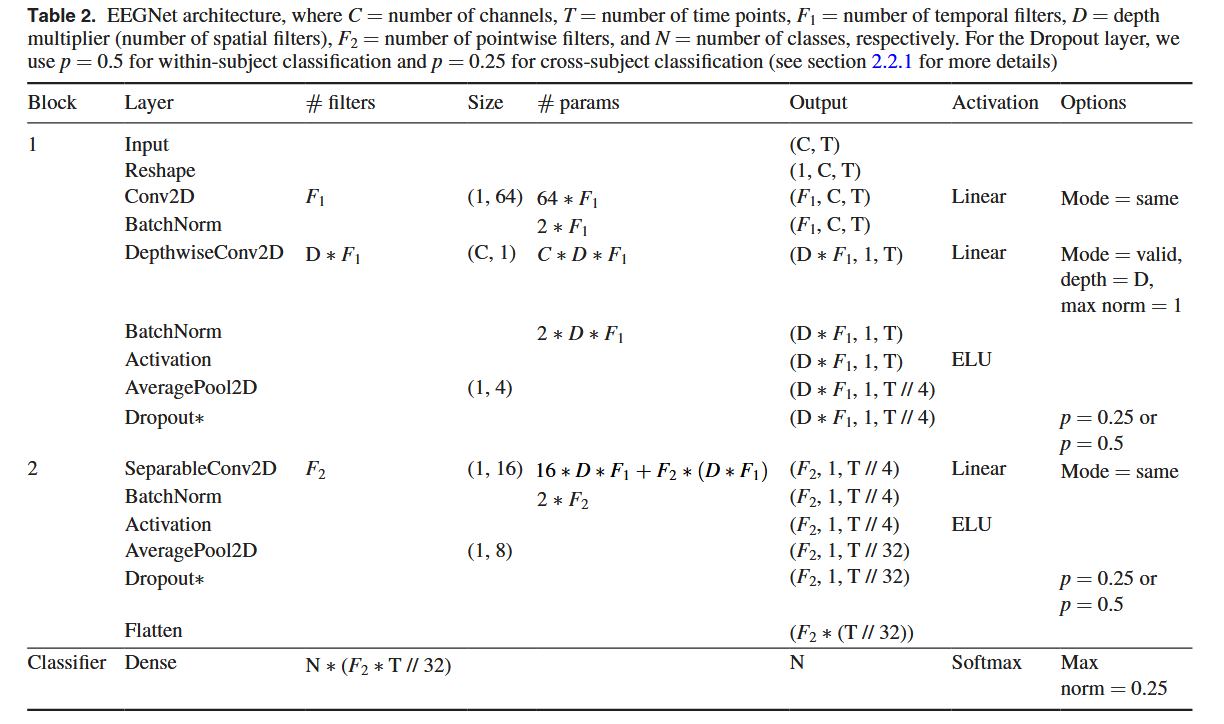

**EEGNet-8,2 parameters:**

F1 = 8 -> temporal filters

D = 2 -> spatial filters

F2 = F1*D -> pointwise convolutions, can be any number but authors choose this

In [56]:
# Define model
class reEEGNet(nn.Module):
    def __init__(self, C, T, F1=8, D=2, p=0.5):
        # C = number of channels, input.shape[1], C = 22 based on 02_preprocessing_pipeline
        # T = number of timepoints per batch, input.shape[2], T = 257 based on 02_preprocessing_pipeline
        # F1 = temporal filters
        # D = spatial filters
        # p = dropout probability: 0.5 for within-subject classification, 0.25 for cross-subject classification

        super().__init__()
        F2 = F1*D # pointwise convolutions, can be any number but authors choose this
        self.temporal = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=F1,
                kernel_size=(1,32),
                padding='same', # keeps initial dims per channel
                groups=1, # default
                bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            # Linear activation = do nothing?
            nn.BatchNorm2d(num_features=F1)) # "We apply batch normalization along the feature map dimension"
        
        self.spatial = nn.Conv2d(
            in_channels=F1,
            out_channels=D*F1,
            kernel_size=(C,1), 
            padding='valid', # no padding -> collapses channel dimension
            groups=F1, # produces depthwise convolution
            bias=False # "We omit the use of bias units in all convolutional layers."
            )
        # "We also regularize each spatial filter by using a maximum norm constraint of 1 on its weights"
        max_norm_value = 1.0 
        self.spatial.weight.register_hook(lambda x: torch.clamp(x, min=-max_norm_value, max=max_norm_value))

        self.aggregation = nn.Sequential(
            nn.BatchNorm1d(num_features=D*F1), # "We apply batch normalization along the feature map dimension"
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,4)), # default stride = kernel_size 
            nn.Dropout(p=p)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d( # depthwise part of separable convolution
            in_channels=D*F1,
            out_channels=D*F1,
            kernel_size=(1,16), 
            padding='same', # keeps initial dims per channel
            groups=D*F1, # produces depthwise convolution
            bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            nn.Conv2d( # pointwise part of separable convolution
            in_channels=D*F1,
            out_channels=F2,
            kernel_size=(1,1), 
            padding='same', # keeps initial dims per channel, shouldn't matter in this case
            groups=1, # default
            bias=False # "We omit the use of bias units in all convolutional layers."
            ),
            # Linear activation = do nothing?
            nn.BatchNorm1d(num_features=F2), # "We apply batch normalization along the feature map dimension"
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1,8)), # default stride = kernel_size
            nn.Dropout(p=p),
            nn.Flatten()
        )

        self.classifier = nn.Linear(
                in_features=F2*(T//32),
                out_features=4, # number of classes
                bias=True # since it's not a convolutional layer..?
            )
        max_norm_value_1 = 0.25 
        self.classifier.weight.register_hook(lambda x: torch.clamp(x, min=-max_norm_value_1, max=max_norm_value_1))
        
        # nn.Softmax(dim=1) # dim = 0 is for batch number; comented out because of nn.CrossEntropyLoss() documentation:
        # "The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general)."



    def forward(self, x):
        x = torch.unsqueeze(x,dim=1) # inserts new dim at specified position, shape = (n_batches, C, T) -> shape = (n_batches, 1, C, T)
        filter_bank = self.temporal(x)
        spatial_pattern = self.spatial(filter_bank)
        block_1_out = self.aggregation(spatial_pattern)
        block_2_out = self.block_2(block_1_out)
        output = self.classifier(block_2_out)
        
        return output

In [57]:
model = reEEGNet(C=dataset.X.shape[1], T=dataset.X.shape[2])

In [58]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's state_dict:
temporal.0.weight 	 tensor([[[[-0.1626, -0.0216,  0.1649,  0.1259, -0.1266,  0.0802, -0.1164,
           -0.0718,  0.0914,  0.1767,  0.0434,  0.1001, -0.1581,  0.0818,
           -0.1585, -0.0623,  0.1233, -0.0630, -0.1343, -0.0951,  0.1182,
           -0.1368,  0.0535,  0.1044,  0.0542,  0.0519,  0.1747, -0.0571,
            0.1068,  0.0363,  0.0524,  0.1243]]],


        [[[-0.1748, -0.0876, -0.0304, -0.0820,  0.0683, -0.1209, -0.0254,
           -0.0548,  0.0727, -0.0266, -0.1083, -0.0966,  0.1192, -0.1519,
            0.0206,  0.0267,  0.0445, -0.0847, -0.1375,  0.0146,  0.0424,
            0.1552,  0.1522, -0.0602, -0.1325, -0.0105,  0.1611,  0.1147,
            0.1656, -0.1524, -0.1576,  0.1524]]],


        [[[ 0.0837,  0.0320,  0.0795,  0.0659,  0.1653, -0.1057,  0.0036,
            0.0817,  0.1699, -0.1411,  0.1009,  0.1251, -0.0281, -0.1433,
           -0.1095,  0.0473,  0.1029, -0.1252,  0.0761, -0.0630, -0.1044,
            0.0157, -0.1354, -0.0813, -0.1

In [59]:
print(model.parameters())

<generator object Module.parameters at 0x00000274111B0A90>


# Training

"We run 500 training iterations (epochs) and perform validation stopping, saving the model weights which produced the lowest validation set loss."

In [60]:
loss_fn = nn.CrossEntropyLoss() # "minimizing the categorical cross-entropy loss function"

# "We fit the model using the Adam optimizer, using default parameters as described in [75]"
# they used tensorflow, for parameters shared with pytorch only eps is slightly different
optimizer = torch.optim.Adam(
    params = model.parameters(),
    eps=1e-07, # the only change from default eps=1e-8, shouldn't matter I think
    foreach=None, # default, "If memory is prohibitive, batch fewer parameters through the optimizer at a time or switch this flag to False"
    fused=None, # default, "To force running the for-loop implementation, pass False for either foreach or fused."
    )

In [61]:
def train(model, optimizer, loss_fn, train_loader, val_loader, nepochs=500):
    '''
    Train a pytorch model and evaluate it every epoch.
    Params:
    model - a pytorch model to train
    optimizer - an optimizer
    loss_fn - the criterion (loss function)
    nepochs - number of training epochs
    train_loader - dataloader for the trainset
    val_loader - dataloader for the valset

    Returns: 
    1. state_dict of the model with the lowest validation loss, 
    2. list of train losses,
    3. list of validation losses.
    '''
    
    train_losses, val_losses = [], []
    best_model = model.state_dict()

    for e in range(nepochs):
        running_loss = 0
        running_val_loss = 0
        for signals, labels in train_loader: # signals = (batch, C, T), labels = (batch, label)

            # Training pass
            model.train() # set model in train mode
            preds = model(signals)
            loss = loss_fn(preds,labels)

            running_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    else:
        val_loss = 0
        # Evalaute model on validation at the end of each epoch.
        with torch.no_grad():
            for signals, labels in val_loader: # signals = (batch, C, T), labels = (batch, label)

                preds = model(signals)
                val_loss = loss_fn(preds,labels)

                running_val_loss += val_loss.item()

        # track train loss and validation loss
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(running_val_loss/len(val_loader))

        if running_val_loss == np.min(np.array(val_losses)):
            best_model = model.state_dict()

        if e%50==0:
            print("Epoch: {}/{}.. ".format(e+1, nepochs),
            "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
            "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))

    return best_model, train_losses, val_losses

In [62]:
"""device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
best_model, train_losses, val_losses = train(model, optimizer, loss_fn, train_loader, val_loader, nepochs=500)"""

'device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"\nprint(f"Using {device} device")\nbest_model, train_losses, val_losses = train(model, optimizer, loss_fn, train_loader, val_loader, nepochs=500)'

In [63]:
#torch.save(best_model, PATH)